In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd 

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# loading data

def load_csv_data(filename):
    csv_path = 'data/' + filename + ".csv"
    return pd.read_csv(csv_path)

sales_data = load_csv_data("sales_train")
item_cat = load_csv_data("item_categories")
items = load_csv_data("items")
shops = load_csv_data("shops")
sample_submission = load_csv_data("sample_submission")
test_data = load_csv_data("test")

In [3]:
sales_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
# change date format
sales_data['date'] = pd.to_datetime(sales_data['date'],format = '%d.%m.%Y')
sales_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [5]:
# feature engineering
# we will prepare time series from our dataset 
# first step - make pivot table
dataset = sales_data.pivot_table(index = ['shop_id','item_id'],
                                 values = ['item_cnt_day'],columns = ['date_block_num'],
                                 fill_value = 0,aggfunc='sum')
dataset.head()

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  

[5 rows x 34 columns]

In [6]:
dataset.reset_index(inplace = True)
dataset.head()

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0  ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

In [7]:
# we will merge our dataset with test data
dataset = pd.merge(test_data,dataset,on = ['item_id','shop_id'],how = 'left')
dataset.head()

/Users/onherknees/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/onherknees/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# fill missing values
dataset.fillna(0,inplace = True)
dataset.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# drop all id data
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
y_train = dataset.values[:,-1:]

X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

In [53]:
# create network
from keras.models import Sequential
from keras.layers import GRU,Dense
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(64, input_shape = (33,1), return_sequences=True),
    keras.layers.GRU(64),
    keras.layers.Dense(1)
])

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=10)

model.compile(loss = 'mse',optimizer = keras.optimizers.Adam(lr=0.005), metrics = ['mean_squared_error'])

In [54]:
history = model.fit(X_train,y_train,batch_size = 4096,epochs = 100, callbacks=[earlystop_callback])

Train on 214200 samples
Epoch 1/100
214200/214200 [==============================] - 56s 259us/sample - loss: 30.1424 - mean_squared_error: 30.1424
Epoch 2/100
214200/214200 [==============================] - 55s 259us/sample - loss: 29.4914 - mean_squared_error: 29.4914
Epoch 3/100
214200/214200 [==============================] - 61s 285us/sample - loss: 29.1911 - mean_squared_error: 29.1911
Epoch 4/100
214200/214200 [==============================] - 67s 315us/sample - loss: 28.9341 - mean_squared_error: 28.9341
Epoch 5/100
214200/214200 [==============================] - 63s 296us/sample - loss: 28.7034 - mean_squared_error: 28.7034
Epoch 6/100
214200/214200 [==============================] - 62s 288us/sample - loss: 28.5868 - mean_squared_error: 28.5868
Epoch 7/100
214200/214200 [==============================] - 62s 291us/sample - loss: 28.2845 - mean_squared_error: 28.2845
Epoch 8/100
214200/214200 [==============================] - 63s 294us/sample - loss: 28.0917 - mean_squared

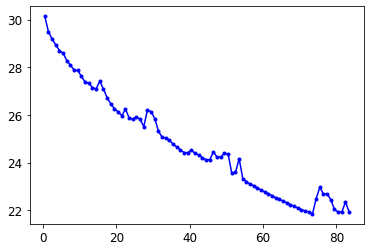

In [55]:
plt.plot(np.arange(len(history.history["loss"])) + 0.5, history.history["loss"], "b.-", label="Training loss")

In [56]:
model.save('model.h5')

In [57]:
y_train_pred = model.predict(X_train)
r2_score(y_train, y_train_pred.clip(0,20))

0.0496574856612636

In [63]:
# creating submission file 
submission_pfs = model.predict(X_test)
submission_pfs = submission_pfs.clip(0,20)
submission = pd.DataFrame({'ID':test_data['ID'],'item_cnt_month':submission_pfs.ravel()})

In [64]:
# creating csv file from dataframe
submission.to_csv('submission.csv',index = False)